In [2]:
%matplotlib notebook

emissions_path = 'inceneritore.csv'
stations_path = 'centraline/stazioni.csv'
drive_path = 'centraline/drive'


S_SO2, S_PM10, S_O3, S_NO2, S_NOX, S_CO, S_C6H6, S_C6H5CH,\
    S_NO, S_C6H4, S_PM25  = 1,5,7,8,9,10,20,21,38,82,111

params = {1: 'SO2',
    5:"PM10",
    7:"O3",
    8:"NO2",
    9:"NOX",
    10:"CO",
    20:"C6H6",
    21:"C6H5-CH",
    38:"NO",
    82:"C6H4",
    111:"PM2.5"}


# Emissions header
E_CO, E_SO2, E_NOX, E_HF, E_PM10, E_COT, E_NH3 = 1,2,3,4,5,6,7
eparams={1:"CO",2:"SO2",3:"NOX",4:"HF",5:"PM10",6:"COT",7:"NH3"}

from collections import defaultdict
from datetime import datetime, timedelta
import glob
import numpy as np
from matplotlib import pylab
from scipy import stats
import seaborn as sns

def smooth(x, window=10, method='hanning'):
    """method='flat', 'hanning', 'hamming', 'bartlett', 'blackman', 'kaiser'"""
    s = np.r_[2 * x[0] - x[window - 1::-1], x, 2 * x[-1] - x[-1:-window:-1]]
    # print(len(s))
    if method == 'flat':  # moving average
        w = np.ones(window, 'd')
    else:
        w = eval('np.' + method + '(window)')
    y = np.convolve(w / w.sum(), s, mode='same')
    y = y[window:-window + 1]
    return y



def correlation_matrix(fields, corr_fields, corr_func=stats.pearsonr):
    """Build a correlation matrix according to a correlation function `corr_func`."""
    N = len(corr_fields)
    r_mat = np.zeros((N,N))
    p_mat = np.zeros((N,N))
    for i, ifield in enumerate(corr_fields):
        for j, jfield in enumerate(corr_fields):
            x, y = np.array(fields[ifield]), np.array(fields[jfield])
            #m = np.isfinite(x)*np.isfinite(y)
            r, p = corr_func(x,y)
            r = abs(r)
            #print(r,p, ifield,jfield)
            r_mat[j,i] = r
            p_mat[j,i] = p
    return r_mat, p_mat

In [3]:
string_keys = [0,1,2,3,4,7,8]

# Cod_Staz replaced by sid key
def load_stations(path):
    stations = {}
    sensors = defaultdict(list)
    keys = []
    for line in open(path,'r'):
        line=line.replace('\n','').split(',')
        if not keys:
            keys=line
            keys[1] = 'sid'
            continue
        if line[2]not in ('MODENA',): # 'SASSUOLO','FIORANO MODENESE', 'MIRANDOLA'):
            continue
        data = {}
        for i,v in enumerate(line):
            if i not in string_keys:
                if not v:
                    v = 0
                elif '.' in v:
                    v = float(v)
                else:
                    v = int(v)
            data[keys[i]] = v
        data['sid'] = data['sid'].replace('.','')
        stations[data['sid']] = data
        sensors[data['sid']].append(data['Id_Param'])
    return stations, sensors

def load_emissions(path):
    data = []
    lastd = None
    for line in open(path,'r'):
        line = line.replace('\n','').split(';')
        if len(line)!=9:
            print('Skip',line)
            continue
        if line[0].count('/')!=2:
            print('Skip', line)
            continue
        dt = datetime.strptime(line[0], '%d/%m/%Y')
        days =[]
        if lastd is None:
            days.append(dt)
        elif (dt-lastd).days>0:
            for i in range((dt-lastd).days):
                d = lastd+timedelta(days=i+1)
                days.append(d)
        lastd = dt
        try:
            v = list(map(float, line[1:]))
        except:
            # Shut down: zero emissions
            v = [0.0]*8
        for d in days:
            data.append([d]+v)
    return np.array(data)

stations, sensors = load_stations(stations_path)
emissions = load_emissions(emissions_path)
print('Emissions:',len(emissions))
zeroday = emissions[0][0]
endday = emissions[-1][0]


Skip ['\xa0', '"HCL ']
Skip ['(mg/Nm3) "', '"CO ']
Skip ['(mg/Nm3) "', '"SO2 ']
Skip ['(mg/Nm3) "', '"NOX ']
Skip ['(mg/Nm3) "', '"HF ']
Skip ['(mg/Nm3) "', '"POLVERI ']
Skip ['(mg/Nm3) "', '"COT ']
Skip ['(mg/Nm3) "', '"NH3 ']
Skip ['(mg/Nm3) "']
Skip ['LIMITI D.Lgs 152/06', '10', '50', '50', '200', '1', '10', '10', '30']
Skip ['LIMITI AIA *', '10', '50', '20', '100', '1', '5', '10', '5']
Emissions: 3686


In [528]:
# Google Drive per centraline:
# https://drive.google.com/drive/folders/0B-owdnU_9_lpei1wbTBpS3RyTW8
import scipy

def uniform_days(data):
    t = data[:,0]
    dd = (t[-1]-t[0]).days
    
    dt = t-t[0]
    # Hourly dt
    hdt = np.array([dt.days*24+dt.seconds/3600. for dt in (dt)])
    # New hourly dt
    newt = np.arange(dd, dtype=float)*24
    # Same-day index
    dindex = np.array([dt.days for dt in (dt)])
    
    # Output day array
    newd = np.array([t[0]+timedelta(days=i) for i in range(dd)])
    vvals=[newd]
    
    ###########
    # Sub-day aggregation
    for delta in range(dd):        
        # Search for sub-day indexes
        sel = np.where(dindex==delta)[0]
        if not len(sel):
            continue
        for vi in range(data.shape[1]-1):
            # Aggregate sub-day indexes by setting them equal their mean
            v = data[sel,vi+1]
            data[sel,vi+1] = np.mean(v)
    
    ###########
    # Daily extrapolation
    for vi in range(data.shape[1]-1):
        v = data[:,vi+1].astype(float)
        # Hourly interpolation
        f = scipy.interpolate.UnivariateSpline(hdt,v,k=1)
        # Daily extrapolation
        v1 = f(newt)
        print(v)
        print(hdt)
        print(newt)
        print(v1)
        vvals.append(v1)
        
    data = np.vstack(vvals).T
    return data
    


def load_station_cron(path):
    global mindate,maxdate
    data = []
    sid = 0
    param = 0
    keys = []
    for i,line in enumerate(open(path,'r')):
        line=line.replace('\n','').split(',')
        if not keys:
            keys = line
            continue
        if 'DATA_INIZIO' in keys:
            val = float(line[-2])            
            df = datetime.strptime(line[3], '%d/%m/%Y %H')
            p = int(line[1])
        elif 'Fine validità (UTC)' in keys:
            val = float(line[-1])
            df = datetime.strptime(line[1].split(' ')[0], '%Y-%m-%d')
            p = -1
        else:
            val = float(line[-1])
            df = datetime.strptime(line[2], '%d/%m/%Y %H:%M')
            p = int(line[1])
            
        if not param:
            param = p
        
        if param>0:
            s = line[0]
            if not sid:
                sid = s
            assert s==sid, '{}!={}'.format(s,sid)
            assert p==param
            assert p in sensors[s]
        
        data.append([df, val])
    
    return data

def load_full_station_cron(station):
    data = {}
    for sensor in sensors[station]:
        s = station
        if len(s)<8:
            s='0'+s
        path = '{}/{}_{:03d}_*.csv'.format(drive_path,s,sensor)
        path1 = '{}/storico_*_{}_{:03d}.csv'.format(drive_path,s,sensor)
        sdata = []
        print(path1)
        print(glob.glob(path)+glob.glob(path1))
        for spath in glob.glob(path)+glob.glob(path1):
            print('Scanning',spath)
            part = load_station_cron(spath)
            print('Loaded', len(part))
            sdata+=part
        #print('For station {} sensor {}, loaded {}'.format(station,sensor,len(sdata)))
        # Order by day from zeroday
        sdata = sorted(sdata, key=lambda e: e[0])
        sdata = np.array(sdata)
        mask = (sdata[:,0]>zeroday)*(sdata[:,0]<endday)
        #print(sdata.shape,sdata[:10])
        sdata = uniform_days(sdata[mask])
        #print(sdata.shape,sdata[:10])
        data[sensor] = sdata
        
        print('Loaded total sensor {} for station {}: {}, deleted {}'.format(station,
                                        sensor,sdata.shape, np.sum(mask==0)))
    return data


In [529]:
station_data = {}
for station in stations.keys():
    data = load_full_station_cron(station)
    station_data[station] = data

centraline/drive/storico_*_04000002_005.csv
['centraline/drive/04000002_005_201907.csv', 'centraline/drive/storico_2015_04000002_005.csv', 'centraline/drive/storico_2017_04000002_005.csv', 'centraline/drive/storico_2011_04000002_005.csv', 'centraline/drive/storico_2016_04000002_005.csv', 'centraline/drive/storico_2018_04000002_005.csv', 'centraline/drive/storico_2010_04000002_005.csv']
Scanning centraline/drive/04000002_005_201907.csv
Loaded 208
Scanning centraline/drive/storico_2015_04000002_005.csv
Loaded 360
Scanning centraline/drive/storico_2017_04000002_005.csv
Loaded 360
Scanning centraline/drive/storico_2011_04000002_005.csv
Loaded 348
Scanning centraline/drive/storico_2016_04000002_005.csv
Loaded 365
Scanning centraline/drive/storico_2018_04000002_005.csv
Loaded 358
Scanning centraline/drive/storico_2010_04000002_005.csv
Loaded 357
[60. 27. 25. ... 14. 22. 26.]
[0.0000e+00 2.4000e+01 4.8000e+01 ... 8.3904e+04 8.3928e+04 8.3952e+04]
[0.0000e+00 2.4000e+01 4.8000e+01 ... 8.3880e+

Loaded 8065
Scanning centraline/drive/storico_2014_04000002_020.csv
Loaded 8056
Scanning centraline/drive/storico_2013_04000002_020.csv
Loaded 8514
Scanning centraline/drive/storico_2011_04000002_020.csv
Loaded 8313
Scanning centraline/drive/storico_2012_04000002_020.csv
Loaded 8455
Scanning centraline/drive/storico_2010_04000002_020.csv
Loaded 8400
Scanning centraline/drive/storico_2016_04000002_020.csv
Loaded 8007
Scanning centraline/drive/storico_2015_04000002_020.csv
Loaded 7733
Scanning centraline/drive/storico_2017_04000002_020.csv
Loaded 7857
[2.03333333 2.03333333 2.03333333 ... 0.3        0.4        0.3       ]
[0.0000e+00 1.0000e+00 2.0000e+00 ... 8.3973e+04 8.3974e+04 8.3975e+04]
[0.0000e+00 2.4000e+01 4.8000e+01 ... 8.3880e+04 8.3904e+04 8.3928e+04]
[1.38752054 1.38740629 1.38729204 ... 0.98822678 0.98811253 0.98799828]
Loaded total sensor 4000002 for station 20: (3498, 2), deleted 0
centraline/drive/storico_*_04000002_038.csv
['centraline/drive/04000002_038_201907.csv', 'c

[40. 14. 16. ...  6.  6.  6.]
[0.0000e+00 2.4000e+01 4.8000e+01 ... 8.3856e+04 8.3880e+04 8.3904e+04]
[0.0000e+00 2.4000e+01 4.8000e+01 ... 8.3832e+04 8.3856e+04 8.3880e+04]
[39.799431   14.28643859 16.15673699 ...  9.3934314   7.9389095
  6.48438759]
Loaded total sensor 4000022 for station 111: (3496, 2), deleted 0


dict_keys(['4000002', '4000022']) dict_keys(['4000002', '4000022'])
[5, 7, 8, 38, 111] ['PM10', 'O3', 'NO2', 'NO', 'PM2.5']


<IPython.core.display.Javascript object>


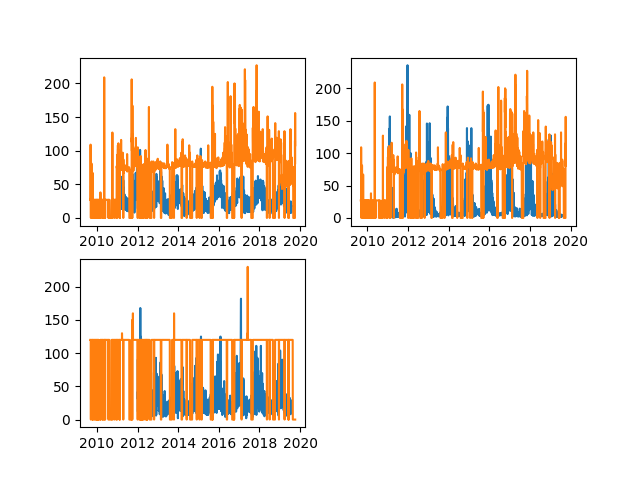

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [10]:
print(stations.keys(), station_data.keys())
s = '4000022'
sens = sensors[s]
print(sens, [params[k] for k in sens])

pylab.figure()
pylab.subplot(2,2,1)
data = station_data[s][S_NO2]
pylab.plot(data[:,0],data[:,1])
pylab.plot(emissions[:,0],emissions[:,E_NOX]*100)

pylab.subplot(2,2,2)
data = station_data[s][S_NO]
pylab.plot(data[:,0],data[:,1])
pylab.plot(emissions[:,0],emissions[:,E_NOX]*100)


pylab.subplot(2,2,3)
data = station_data[s][S_PM10]
pylab.plot(data[:,0],data[:,1])
pylab.plot(emissions[:,0],emissions[:,E_PM10]*1000)


#pylab.subplot(2,2,4)
#data = station_data[s][S_C6H6]
#pylab.plot(data[:,0],data[:,1])
#pylab.plot(emissions[:,0],emissions[:,E_COT])





<IPython.core.display.Javascript object>


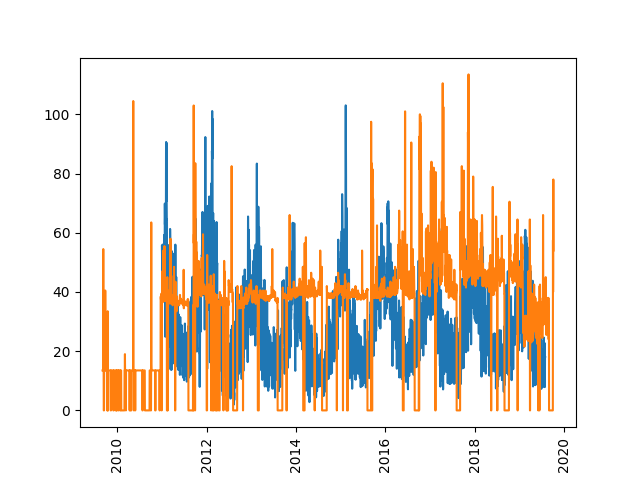

<IPython.core.display.Javascript object>


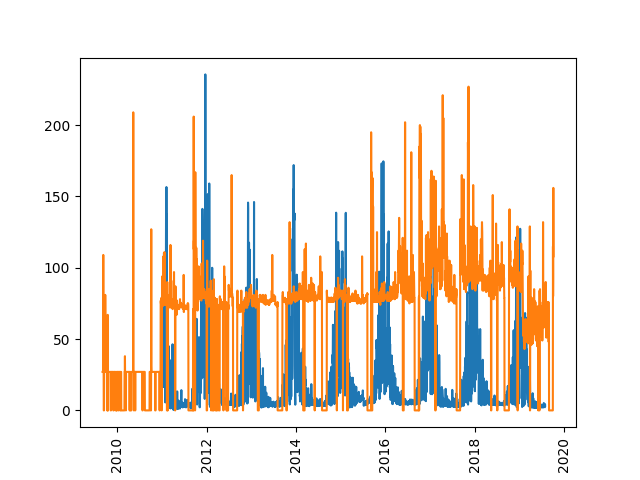

(array([733042., 733773., 734503., 735234., 735964., 736695., 737425.]),
 <a list of 7 Text xticklabel objects>)

In [48]:
pylab.figure()
data = station_data[s][S_NO2]
pylab.plot(data[:,0],data[:,1])
pylab.plot(emissions[:,0],emissions[:,E_NOX]*50)
pylab.xticks(rotation=90)
#print(data[-50:,:])

pylab.figure()
data = station_data[s][S_NO]
pylab.plot(data[:,0],data[:,1])
pylab.plot(emissions[:,0],emissions[:,E_NOX]*100)
pylab.xticks(rotation=90)


<IPython.core.display.Javascript object>


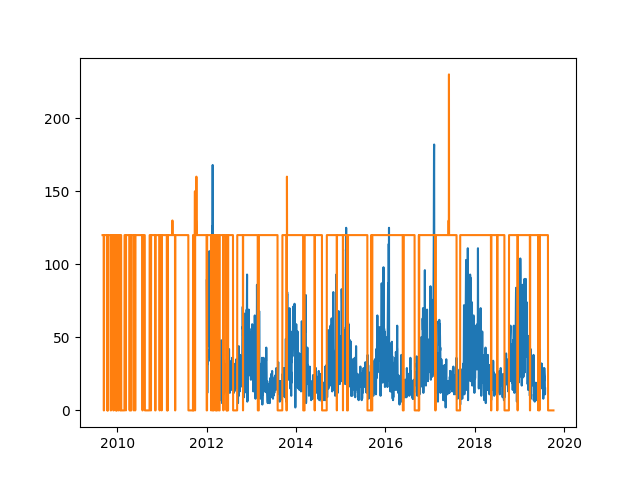

In [49]:
pylab.figure()
data = station_data[s][S_PM10]
pylab.plot(data[:,0],data[:,1])
pylab.plot(emissions[:,0],emissions[:,E_PM10]*1000)

In [126]:
# Load temperature data
T = load_station_cron('temperature_mean_modena.csv')
T = np.array(sorted(T, key=lambda e: e[0]))
print(zeroday,endday)
T = uniform_days(T)


2009-09-03 00:00:00 2019-10-06 00:00:00
[25.8  26.82 27.   ... 11.88  9.92 11.28]
[0.0000e+00 2.4000e+01 4.8000e+01 ... 8.9040e+04 8.9064e+04 8.9088e+04]
[0.0000e+00 2.4000e+01 4.8000e+01 ... 8.9016e+04 8.9040e+04 8.9064e+04]
[26.14408363 26.38819406 26.63230449 ... 13.82978965 12.81987979
 11.80996992]


Selecting between 2012-01-23 00:00:00 2019-07-30 01:00:00


<IPython.core.display.Javascript object>


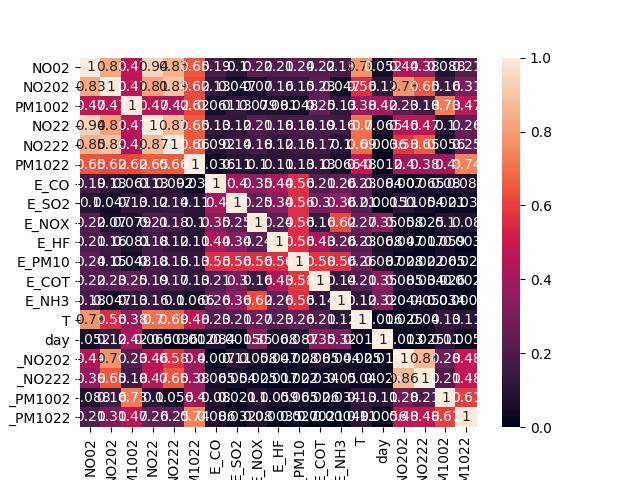

In [514]:
corr_map = {}

for s in stations.keys():
    for p in 38,8,5:
        dat = station_data[s][p]
        corr_map[params[p]+s[-2:]] = dat
for ei,ek in eparams.items():
    corr_map['E_'+ek] = emissions[:,[0,ei]]


corr_map['T'] = T
    
def fix_correlated_map(cmap):
    mindate,maxdate=zeroday,endday
    for k,dat in cmap.items():
        if dat[0][0]>mindate:
            mindate = dat[0][0]
        elif dat[-1][0]<maxdate:
            maxdate = dat[-1][0]
    print('Selecting between',mindate,maxdate)
    new = {}
    for k,dat in cmap.items():
        cron = dat[:,0]
        mask = (cron<maxdate)*(cron>mindate)
        new[k]=dat[mask,1].astype(float)
        #print(k,len(new[k]), dat[mask][0,0], dat[mask][-1,0])
    new['day'] = np.arange((maxdate-mindate).days)
    return new, mindate,maxdate


corr_map,mindate,maxdate = fix_correlated_map(corr_map)

mask = (T[:,0]>mindate)*(T[:,0]<maxdate)
T = T[mask]
#pylab.figure()
def temperature_norm(key):
    full = np.polyfit(corr_map['T'],corr_map[key], 3, full=True)
    fit = np.polyval(full[0],corr_map['T'])
    
    # Time fit
    full = np.polyfit(corr_map['day'],corr_map[key]-fit, 1, full=True)
    tfit = np.polyval(full[0],corr_map['day'])
    
    #pylab.plot(corr_map[key]-fit-tfit,'.')
    #pylab.plot(fit,'.')
    #pylab.plot(tfit,'.')
    corr_map['_'+key]=corr_map[key]-fit-tfit
    corr_map['f'+key]=fit
    corr_map['t'+key]=tfit
    
temperature_norm('NO202')
temperature_norm('NO222')
temperature_norm('PM1002')
temperature_norm('PM1022')


corr_fields = list(filter(lambda e: e[0] not in 'ft', corr_map.keys()))
r_matp, p_matp = correlation_matrix(corr_map, corr_fields=corr_fields, 
                                    corr_func=stats.spearmanr)
pylab.figure()
sns.heatmap(r_matp, xticklabels=corr_fields, yticklabels=corr_fields, 
            vmin=0, vmax=1, annot=True)

<IPython.core.display.Javascript object>


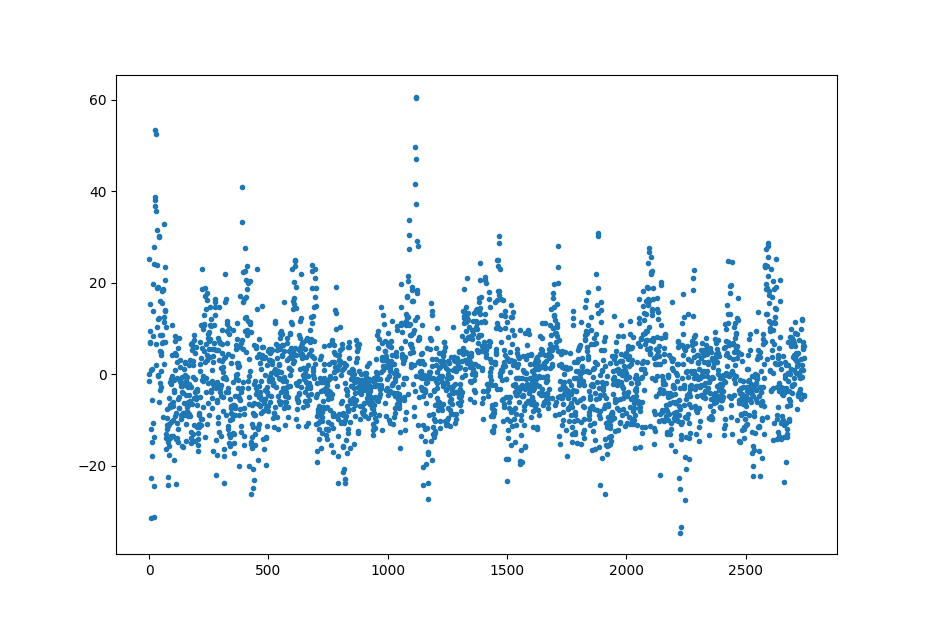

<IPython.core.display.Javascript object>


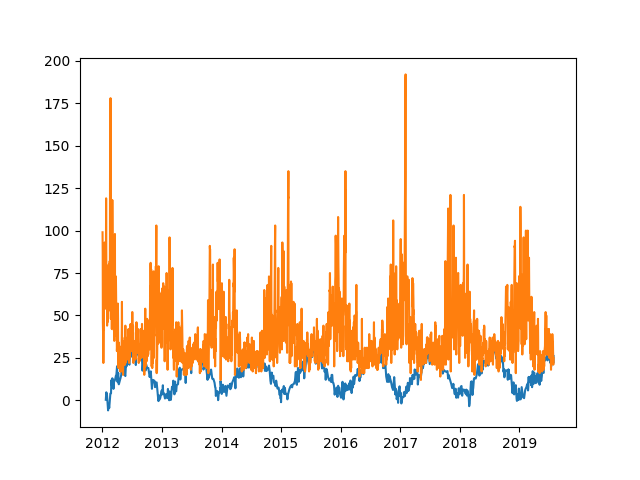

In [370]:



data = station_data[s][S_NO2]
pylab.figure()
#pylab.plot(corr_map['day'],corr_map['T'],'.')
#pylab.plot(corr_map['day'],corr_map['NO222'],'.')
pylab.plot(corr_map['day'],corr_map['_NO222'],'.')
#pylab.plot(corr_map['day'],corr_map['fNO222'],'.')
#pylab.plot(corr_map['day'],corr_map['tNO222'],'.')

data = station_data[s][S_PM10]
pylab.figure()
pylab.plot(T[:,0],T[:,1])
pylab.plot(data[:,0],data[:,1]+10)

<IPython.core.display.Javascript object>


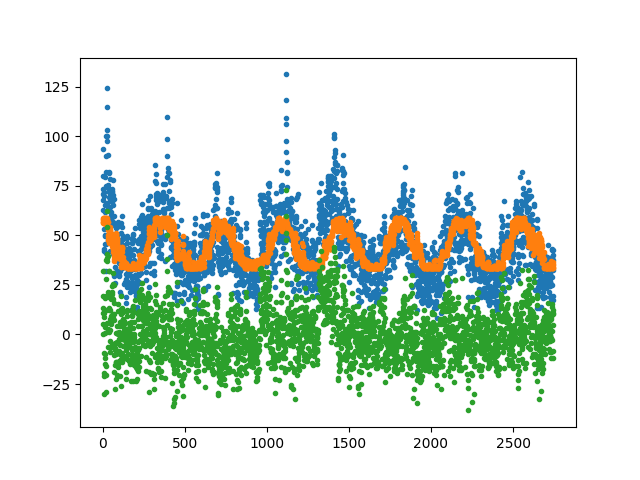

7.118360425234058e-15 12.991190587843965
44.22687079362824 8.776283136507587
44.22687079362824 15.826880533502152
0.9999999999999999


In [348]:
pylab.figure()
pylab.plot(corr_map['day'],corr_map['NO202'],'.')
pylab.plot(corr_map['day'],corr_map['fNO202'],'.')
pylab.plot(corr_map['day'],corr_map['_NO202'],'.')
#pylab.plot(corr_map['day'],corr_map['NO222'])
#pylab.plot(corr_map['day'],corr_map['E_NOX']*40)

print(corr_map['_NO202'].mean(),corr_map['_NO202'].std())
print(corr_map['fNO202'].mean(),corr_map['fNO202'].std())
print(corr_map['NO202'].mean(),corr_map['NO202'].std())
print(corr_map['fNO202'].sum()/corr_map['NO202'].sum())


Stops: 64


<IPython.core.display.Javascript object>


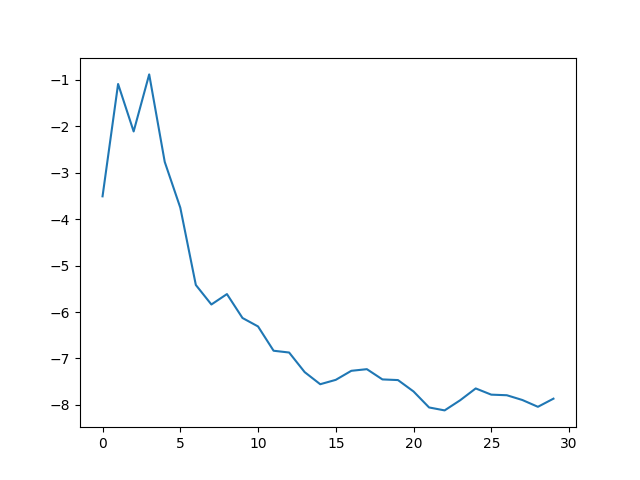

<IPython.core.display.Javascript object>


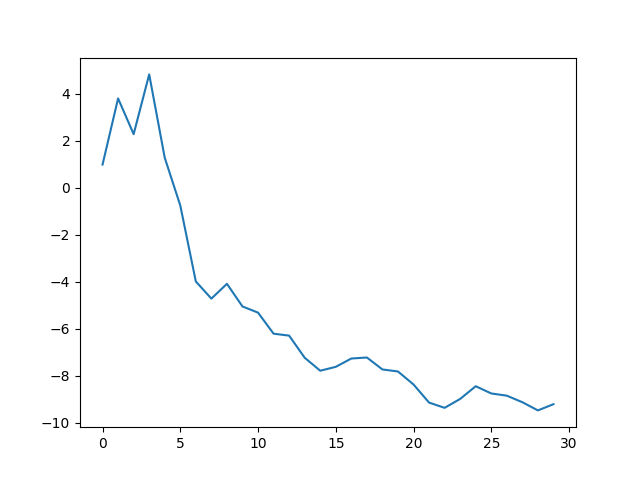

In [521]:
def reject_outliers(data, m=2):
    mask = abs(data - np.mean(data)) < m * np.std(data)
    return mask

def identify_zero_emission_days(emissions):
    totals = emissions[:,1:].sum(1)
    days = np.where(totals==0)[0]
    #days = np.concatenate((np.array([0]), days))
    diff = np.diff(days)
    segments = np.where(diff>1)[0]
    events = [] # start,end
    start = days[0]
    for sg in segments:
        # End of previous
        end = days[sg]
        events.append((start, end))
        assert totals[start:end+1].sum()==0
        # Start new one
        start = days[sg+1]
    return events

stops = identify_zero_emission_days(emissions)
print("Stops:",len(stops))
# 02 = via giardini
# 22 = parco ferrari
def analyze_stops(stops, pre_margin, post_margin, var = '_NO222'):
    N = len(corr_map['day'])
    ratios = []
    outvals = []
    dates = []
    for start,end in stops:
        #if end<start+1:
        #    continue
        d = emissions[start][0]
        si = (d-mindate).days
        if si<pre_margin:
            #print('skip', emissions[start][0], mindate)
            continue
        ei = (emissions[end][0]-mindate).days
        if si>=N-1-post_margin:
            continue
        dates.append(d)
        #print('plot', si,ei, emissions[start][0], emissions[end][0])
        #print(days)
        vpre = corr_map[var][si-pre_margin:si]
        #vpost = corr_map[var][ei+1:ei+2+post_margin]
        vpost = corr_map[var][si+1:si+2+post_margin]
        vm0,vm1 = vpre.mean(), vpost.mean()
        #print(post_margin, vm0,vm1)
        if var.startswith('_'):
            var1 = var[1:]
            # Whole mean
            div = corr_map[var1][si-pre_margin:si+2+post_margin].mean()
            r = 2*(vm1-vm0)/div
        else:
            div = vm1+vm0
            r = 2*(vm1-vm0)/div
        
        ratios.append(r)
        vals = np.concatenate((vpre, vpost))
        outvals.append(vals)
    #print('Valid:',len(dates),pre_margin,post_margin)
    return np.array(dates), outvals, np.array(ratios)

pre_margin = 15
cutoff = 2
end_scan = 30
nmeans = []
rmeans = []
#pylab.figure()
for post in range(0,end_scan):
    dates, outvals, ratios = analyze_stops(stops, pre_margin,post, 'NO222')
    # Remove above 200%
    mask = (ratios<cutoff)*(ratios>-cutoff)
    nratios = ratios[mask]
    #pylab.plot(dates[mask],nratios*100)
    nmeans.append(np.mean(nratios)*100)
    rmeans.append(np.mean(ratios)*100)
    #print('{}: {:.2f} ({:.1f})'.format(post, nmeans[-1], rmeans[-1]))
    
pylab.figure()
pylab.plot(nmeans)


nmeans = []
rmeans = []
#pylab.figure()
for post in range(0,end_scan):
    dates, outvals, ratios = analyze_stops(stops, pre_margin,post, '_NO222')
    # Remove above 200%
    mask = (ratios<cutoff)*(ratios>-cutoff)
    nratios = ratios[mask]
    #pylab.plot(dates[mask],nratios*100)
    nmeans.append(np.mean(nratios)*100)
    rmeans.append(np.mean(ratios)*100)
    #print('{}: {:.2f} ({:.1f})'.format(post, nmeans[-1], rmeans[-1]))
    
pylab.figure()
pylab.plot(nmeans)


<IPython.core.display.Javascript object>


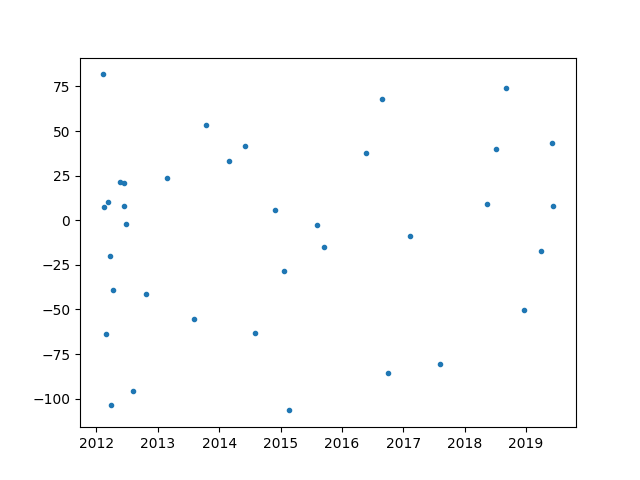

<IPython.core.display.Javascript object>


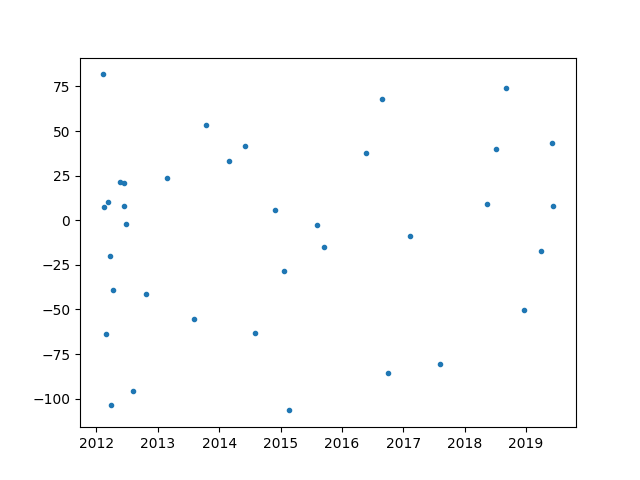

-8.12608103487354
-8.12608103487354


In [530]:
pre_margin = 14
post_margin = 14
dates, outvals, ratios = analyze_stops(stops, pre_margin,post_margin, '_NO222')

#pylab.figure()
#for vals in outvals:
#    pylab.plot(np.arange(len(vals))-pre_margin,vals,'.')

ratios = np.array(ratios)
mask = (ratios<2)*(ratios>-2)

nratios = ratios[mask]
ndates = dates[mask]
pylab.figure()
pylab.plot(ndates, nratios*100,'.')



pylab.figure()
pylab.plot(ndates,nratios*100,'.')
print(np.mean(ratios)*100)
print(np.mean(nratios)*100)

<IPython.core.display.Javascript object>


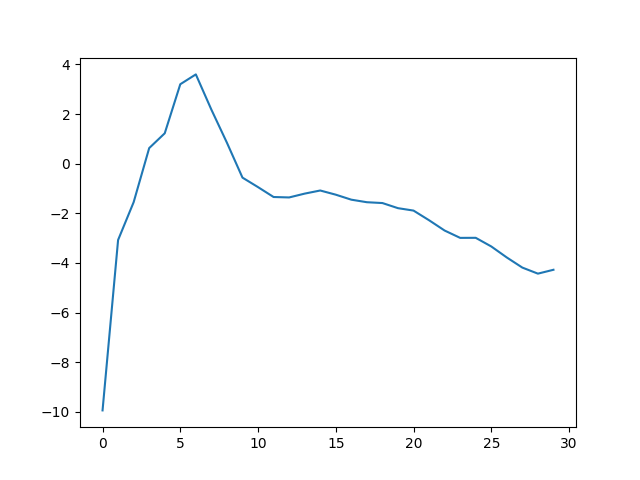

In [475]:

N = len(corr_map['day'])
rand_stops = []
for u in range(30):
    s = np.random.choice(N-50)
    rand_stops.append((s,s))
nmeans=[]
rmeans = []
for post in range(0,30):
    dates, outvals, ratios = analyze_stops(rand_stops, 14,post)
    # Remove above 200%
    mask = (ratios<cutoff)*(ratios>-cutoff)
    nratios = ratios[mask]
    #pylab.plot(dates[mask],nratios*100)
    nmeans.append(np.mean(nratios)*100)
    rmeans.append(np.mean(ratios)*100)
    #print('{}: {:.2f} ({:.1f})'.format(post, nmeans[-1], rmeans[-1]))
pylab.figure()
pylab.plot(nmeans)

In [513]:
def random_selection(nstops=43,pre=14,post=360):
    N = len(corr_map['day'])
    rand_stops = []
    for u in range(nstops):
        s = np.random.choice(N-50)
        rand_stops.append((s,s))
    dates, outvals, ratios = analyze_stops(rand_stops, pre, post, var='_NO222')
    # Remove above 200%
    mask = (ratios<cutoff)*(ratios>-cutoff)
    nratios = ratios[mask]
    n,r = np.mean(nratios), np.mean(ratios)
    return n,r

out = np.array([random_selection() for i in range(1000)])
print(np.mean(out[:,0])*100)
print(np.mean(out[:,1])*100)



3.5144991685031957
0.12491979673681336


In [ ]:
# Lista blocchi del traffico